<a href="https://colab.research.google.com/github/sihan827/2021_Winter_PE/blob/main/model_implementation/alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 전역 변수들
# 에폭, 배치 크기
EPOCHS = 20
BATCH_SIZE = 128

In [6]:
# CIFAR-10 데이터 관련 라이브러리
from torchvision import utils, transforms, datasets
from torch.utils import data
import torch

In [7]:
# 이미지 전처리 과정
# 크기 256으로 맞춘 후 중앙에서 (224, 224) 크기로 자름
# 수평으로 뒤집기 시행, 평균과 표준편차로 정규화
preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 훈련 데이터 및 테스트 데이터 셋
train_set = datasets.CIFAR10(
    '/content/drive/My Drive/.data',
    train=True,
    download=True,
    transform=preprocess
)
test_set = datasets.CIFAR10(
    '/content/drive/My Drive/.data',
    train=False,
    download=True,
    transform=preprocess
)

# 훈련 데이터 및 테스트 데이터 로더
train_loader = data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
test_loader = data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# 데이터 셋 크기 체크
print(len(train_set))
print(len(test_set))

50000
10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


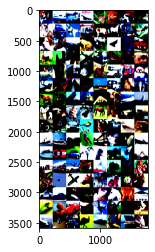

In [9]:
# 데이터가 잘 다운로드되었는지 배치 하나를 불러와서 matplotlib으로 출력
import matplotlib.pyplot as plt
import numpy as np
diatater = iter(test_loader)
batch_img, labels = diatater.next()
img_grid = utils.make_grid(batch_img, padding=0)
npimg_grid = img_grid.numpy()
plt.imshow(np.transpose(npimg_grid, (1, 2, 0)))
plt.show()

In [10]:
# torch 신경망 관련 라이브러리
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# AlexNet 모델로 구현
class AlexNet(nn.Module):
  def __init__(self, labels=10):
    super(AlexNet, self).__init__()
    # 합성곱 층 5개
    self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)
    self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
    # 완전연결 층 3개
    self.fc1 = nn.Linear(9216, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, labels)

    
  def forward(self, x):
    # conv1->relu->maxpool
    output = F.relu(self.conv1(x))
    output = F.max_pool2d(output, 3, stride=2)
    # conv2->relu->maxpool
    output = F.relu(self.conv2(output))
    output = F.max_pool2d(output, 3, stride=2)
    # conv3->relu
    output = F.relu(self.conv3(output))
    # conv4->relu
    output = F.relu(self.conv4(output))
    # conv5->relu->maxpool
    output = F.relu(self.conv5(output))
    output = F.max_pool2d(output, 3, stride=2)
    # 텐서 펴기
    output = output.view(-1, 9216)
    # fc1 이전 dropout
    output = F.dropout(output)
    # fc1->relu
    output = F.relu(self.fc1(output))
    # fc2 이전 dropout
    output = F.dropout(output)
    # fc2->relu
    output = F.relu(self.fc2(output))
    # fc3
    # output = F.softmax(self.fc3(output), dim=1)
    output = self.fc3(output)
    return output

In [12]:
# cuda 설정
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print(DEVICE)

cuda


In [13]:
# 훈련 과정 함수 정의
def train(model, train_loader, optimizer, epochs):
  model.train()
  running_loss = 0
  for epoch in range(epochs):
    for idx, (data, target) in enumerate(train_loader, 0):
      data, target = data.to(DEVICE), target.to(DEVICE)

      optimizer.zero_grad()
      output = model(data)
      loss = F.cross_entropy(output, target)
      loss.backward()
      optimizer.step()
      if idx % 60 == 0:
        print('[%d %5d] loss : %f' % (epoch, idx, loss.item()))
  print('done!')

In [18]:
# 테스트 함수 정의
def test(model, test_loader):
  model.eval()
  correct = 0
  test_loss = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(DEVICE), target.to(DEVICE)
      output = model(data)
      test_loss += F.cross_entropy(output, target, reduction='sum').item()
      pred = torch.max(output, 1)[1]
      correct += (pred == target).sum().item()
    data_size = len(test_loader.dataset)
    test_loss /= data_size
    accuracy = correct / data_size * 100
    return test_loss, accuracy

In [15]:
# 모델 생성
alexmodel = AlexNet().to(DEVICE)
# SGD로 최적화
# 관성 0.9, 가중치감소 0.00005
# 학습률은 0.01로 초기화
optimizer = torch.optim.SGD(alexmodel.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00005)

In [16]:
train(alexmodel, train_loader, optimizer, EPOCHS)

[0     0] loss : 2.304159
[0    60] loss : 2.298541
[0   120] loss : 2.279414
[0   180] loss : 2.015463
[0   240] loss : 1.919107
[0   300] loss : 1.850011
[0   360] loss : 1.707053
[1     0] loss : 1.713838
[1    60] loss : 1.563738
[1   120] loss : 1.567040
[1   180] loss : 1.433649
[1   240] loss : 1.456878
[1   300] loss : 1.357293
[1   360] loss : 1.309605
[2     0] loss : 1.563556
[2    60] loss : 1.553040
[2   120] loss : 1.364538
[2   180] loss : 1.381162
[2   240] loss : 1.157402
[2   300] loss : 1.069121
[2   360] loss : 1.167176
[3     0] loss : 1.187738
[3    60] loss : 1.137152
[3   120] loss : 1.097521
[3   180] loss : 0.887114
[3   240] loss : 1.014183
[3   300] loss : 0.918033
[3   360] loss : 1.119162
[4     0] loss : 0.799336
[4    60] loss : 0.771213
[4   120] loss : 0.757763
[4   180] loss : 0.755970
[4   240] loss : 0.729782
[4   300] loss : 0.760945
[4   360] loss : 0.826804
[5     0] loss : 0.920262
[5    60] loss : 0.608431
[5   120] loss : 0.842229
[5   180] lo

In [21]:
test_loss, accuracy = test(alexmodel, test_loader)
print('Test Loss: %.5f' % (test_loss))
print('Accuracy: %.2f %%' % (accuracy))

Test Loss: 0.53512
Accuracy: 83.98 %
